In [360]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [361]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [362]:
import pandas as pd
from thefuzz import fuzz

def bipartite_metric(model_answers: pd.DataFrame, ground_truth: pd.DataFrame):    
    scores = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.partial_ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .sub(60) \
        .clip(lower=0) \
        .div(40) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index() \
        .join(model_answers["sentence"], on="index") \
        .rename(columns={"sentence": "model"}) \
        .join(ground_truth, on="variable") \
        .rename(columns={"sentence": "truth", "value": "score"})
        
    scores = scores[["comedian", "model", "truth", "score"]]
    
    df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()
    
    truths = scores[~scores['truth'].isin(df['truth'])]
    entries = truths.copy()
    # entries['score'] = 0
    df = pd.concat([df, entries[['comedian', 'model', 'truth', 'score']]], ignore_index=True)
    df.sort_values(by=['comedian', 'model'], inplace=True)
    
    return df.groupby("truth")["score"].mean().reset_index()

In [363]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

/tmp/ipykernel_2094042/1879101266.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [364]:
gemma_metric

,truth,score
0,"""Alright, you guys are all killing it academic...",0.500000
1,"""Because we don't say that when someone gives ...",0.000000
2,"""Click the links below, subscribe, leave a com...",0.000000
3,"""Does the front door not work?"" ""No, it works.",0.000000
4,"""Hi, everyone, same old me.""",0.000000
...,...,...
241,[audience cheers and applauds] He's a surfer. ...,0.500000
242,"[audience laughing] Very sorry, Radio City, di...",0.318750
243,[laughs] It just doesn't work. I remember when...,0.808333
244,[laughter] That kid won't choke on camera. He'...,0.737500


In [365]:
gemma_metric["score"].mean() * 100

14.200711382113823

In [366]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [367]:
brute_model = pd.DataFrame(brute_sentences)

In [368]:
brute = bipartite_metric(brute_model, ground_truth)

/tmp/ipykernel_2094042/1879101266.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [369]:
brute["score"].mean() * 100

11.612020557212384

In [370]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() * 100

/tmp/ipykernel_2094042/1879101266.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


11.177180120015484

In [371]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [372]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

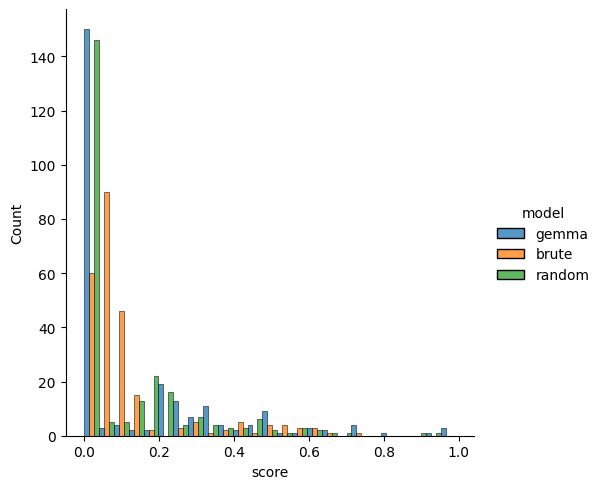

In [373]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [374]:
phi_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/phi3_mini_quotes.csv")
phi_metric = bipartite_metric(phi_model, ground_truth)
phi_metric["score"].mean() * 100

/tmp/ipykernel_2094042/1879101266.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


12.956639566395662

In [375]:
phi = phi_metric.assign(model="phi") 

In [376]:
llm = pd.concat([gemma, phi, brute, random]).reset_index(drop=True)

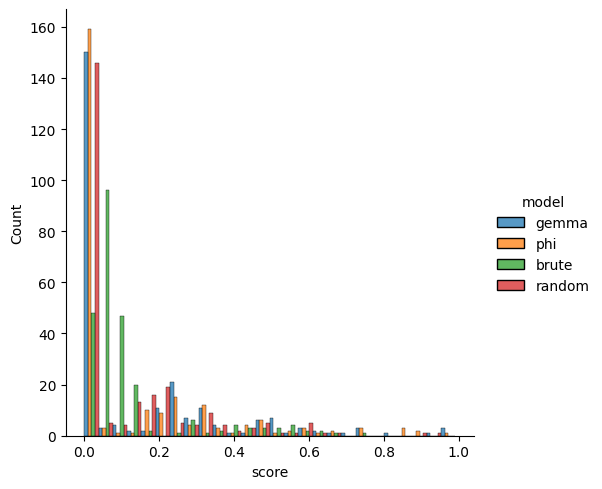

In [377]:
sns.displot(llm, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

ChatGPT

In [378]:
chat_gpt = pd.read_csv('/home/ada/humor/data/stand_up_dataset/Chat_GPT_results - Sheet1.csv')
chat_gpt_metric = bipartite_metric(chat_gpt, ground_truth[ground_truth["comedian"]=="Jimmy_Yang"])


/tmp/ipykernel_2094042/1879101266.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [379]:
ground_truth[ground_truth["comedian"]=="Jimmy_Yang"]

,comedian,laugh_start,laugh_end,sentence
138,Jimmy_Yang,4.7230,6.042,"Asian people, we don't need Tinder anymore. We..."
139,Jimmy_Yang,25.1675,27.876,I think tall women are beautiful. But some of ...
140,Jimmy_Yang,35.6550,36.360,"She's like, it makes my ass look better. I'm l..."
141,Jimmy_Yang,40.2820,41.856,"Neither of us look good, OK?"
142,Jimmy_Yang,81.6720,83.525,I was frustrated. I had enough.
143,Jimmy_Yang,88.1520,89.044,"So I just looked up at her, I was like, hey!"


In [380]:
chat_gpt

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...


In [381]:
chat_gpt_metric

,truth,score
0,"Asian people, we don't need Tinder anymore. We...",0.139286
1,I think tall women are beautiful. But some of ...,0.142857
2,I was frustrated. I had enough.,0.142857
3,"Neither of us look good, OK?",0.142857
4,"She's like, it makes my ass look better. I'm l...",0.135714
5,"So I just looked up at her, I was like, hey!",0.567857


In [382]:
chat_gpt_metric["score"].mean() * 100

21.19047619047619